## Installing Required Libraries

In [1]:
%pip install azure-cognitiveservices-speech openai
%pip install soundfile
%pip install pyaudio
%pip install langchain-core langgraph>0.2.27
%pip install -q langchain-google-genai
%pip install -q google-generativeai
%pip install pyyaml

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Importing Required Modules

In [2]:
import os
import google.generativeai as genai
import json
import math
import requests
import sys
import time
import threading
import wave
import pyaudio

import numpy as np
import soundfile as sf

from typing_extensions import TypedDict
from typing import Any, Dict, List, Optional, Tuple

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

import yaml
import copy

import simpleaudio as sa


try:
    import azure.cognitiveservices.speech as speechsdk
except ImportError:
    print("""
    Importing the Speech SDK for Python failed.
    Refer to
    https://docs.microsoft.com/azure/cognitive-services/speech-service/quickstart-python for
    installation instructions.
    """)
    raise ImportError("Error importing the Speech SDK for Python.")

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Audio Chat Agent

### Acquire Keys and Environment Variables

In [3]:
# Load the YAML file
with open("../config.yaml", "r") as file:
    config = yaml.safe_load(file)

# Load the API key
os.environ["GOOGLE_API_KEY"] = config["google_cloud_info"]["google_cloud_api_key"]
speech_key = config["azure_info"]["azure_speech_key"]
service_region = config["azure_info"]["azure_service_region"]

### Utils

In [4]:
## util functions
def read_wave_header(file_path):
    with wave.open(file_path, 'rb') as audio_file:
        framerate = audio_file.getframerate()
        bits_per_sample = audio_file.getsampwidth() * 8
        num_channels = audio_file.getnchannels()
        return framerate, bits_per_sample, num_channels
    
def push_stream_writer(stream, filenames, merged_audio_path, sample_rate, channels, sample_width): 
    byte_data = b""
    # The number of bytes to push per buffer
    n_bytes = 3200
    try:
        for filename in filenames:
            wav_fh = wave.open(filename)
            # Start pushing data until all data has been read from the file
            try:
                while True:
                    frames = wav_fh.readframes(n_bytes // 2)
                    if not frames:
                        break
                    stream.write(frames)
                    byte_data += frames
                    time.sleep(.1)
            finally:
                wav_fh.close()
        with wave.open(merged_audio_path, 'wb') as wave_file:
            wave_file.setnchannels(channels)
            wave_file.setsampwidth(sample_width)
            wave_file.setframerate(sample_rate)
            wave_file.writeframes(byte_data)
    finally:
        stream.close()

def merge_wav(audio_list, output_path, sample_rate, tag=None): 
    combined_audio = np.empty((0,))
    for audio in audio_list:
        y, _ = sf.read(audio, dtype="float32")
        combined_audio = np.concatenate((combined_audio, y))
        os.remove(audio)
    sf.write(output_path, combined_audio, sample_rate)
    if tag:
        print(f"Save {tag} to {output_path}")

def get_mispronunciation_clip(offset, duration, save_path, merged_audio_path, sample_rate, reduced_unit): 
    y, _ = sf.read(
        merged_audio_path,
        start=int((offset) / reduced_unit * sample_rate),
        stop=int((offset + duration) / reduced_unit * sample_rate),
        dtype=np.float32
    )
    sf.write(save_path, y, sample_rate)

def strip_end_silence(file_path, sample_rate):
    y, _ = sf.read(file_path, start=0, stop=-int(sample_rate*0.8), dtype=np.float32)
    sf.write(file_path, y, sample_rate)

def save_audio(filename, format_, channels, rate, chunk, recording_event):
    """
    Save audio from the microphone in parallel using PyAudio.
    """
    p = pyaudio.PyAudio()
    stream = p.open(format=format_, channels=channels, rate=rate, input=True, frames_per_buffer=chunk)
    frames = []

    print("Recording audio...")
    start_time = time.time()    

    while recording_event.is_set():
        data = stream.read(chunk)
        frames.append(data)
    print("Stopping audio recording...")
    stream.stop_stream()
    stream.close()
    p.terminate()

    # Save the recorded frames as a .wav file
    
    with wave.open(filename, 'wb') as wf:
        wf.setnchannels(channels)
        wf.setsampwidth(p.get_sample_size(format_))
        wf.setframerate(rate)
        wf.writeframes(b''.join(frames))
    print(f"Audio saved to {filename}")

    strip_end_silence(filename, rate)

def play_audio_with_pyaudio(wav_file_path):
    # Open the WAV file
    wf = wave.open(wav_file_path, 'rb')

    # Create a PyAudio instance
    p = pyaudio.PyAudio()

    # Open a stream for playback
    stream = p.open(
        format=p.get_format_from_width(wf.getsampwidth()),
        channels=wf.getnchannels(),
        rate=wf.getframerate(),
        output=True
    )

    # Read data in chunks
    chunk = 1024
    data = wf.readframes(chunk)

    # Play the sound by writing audio data to the stream
    while data:
        stream.write(data)
        data = wf.readframes(chunk)

    # Stop and close the stream
    stream.stop_stream()
    stream.close()

    # Close PyAudio
    p.terminate()

    # Close the WAV file
    wf.close()

def invoke_chatbot(messages, temperature):
    llm = ChatGoogleGenerativeAI(model='gemini-1.5-pro', temperature=temperature)
    response = llm.invoke(messages)
    content = response.content
    input_tokens = response.usage_metadata["input_tokens"]
    output_tokens = response.usage_metadata["output_tokens"]
    messages.append(AIMessage(content=content))
    
    return messages, input_tokens, output_tokens

### Defining Classes and Objects

In [5]:
class TokenCount(TypedDict):
    action: str
    input_tokens: int
    output_tokens: int

class AudioParams(TypedDict):
    sample_rate: int
    channels: int
    sample_width: int
    format_: int   
    chunk: int

class AgentState(TypedDict):
    messages: List[str]
    actions: List[str]
    action_num: int
    max_speaking_time: int ## contains the maximum speaking time in seconds
    audio_params: AudioParams
    token_usage_history: List[TokenCount]
    total_input_tokens: int
    total_output_tokens: int

### Define Agent Tools and Functions

In [6]:
# Define the functions for each node

def stt(state: AgentState) -> AgentState:
    """
    Convert speech to text in real-time from microphone input.
    """
    result_text = []
    updated_state = copy.deepcopy(state)
    speech_config = speechsdk.SpeechConfig(subscription=speech_key, region=service_region)
    audio_config = speechsdk.audio.AudioConfig(use_default_microphone=True)

    speech_recognizer = speechsdk.SpeechRecognizer(speech_config=speech_config, audio_config=audio_config)

    done = False
    audio_args = state["audio_params"]

    def stop_cb(evt: speechsdk.SessionEventArgs):
        """Callback that signals to stop continuous recognition upon receiving an event `evt`."""
        nonlocal done
        done = True

    speech_recognizer.recognized.connect(lambda evt: result_text.append(evt.result.text))
    speech_recognizer.session_stopped.connect(stop_cb)
    speech_recognizer.canceled.connect(stop_cb)

    speech_recognizer.start_continuous_recognition()
    print("Please speak into the microphone...")

    global recording_event
    filename = f"input_audio_{state["action_num"]}.wav"
    recording_event = threading.Event()
    recording_event.set()
    audio_thread = threading.Thread(target=save_audio, args=(filename, audio_args["format_"], audio_args["channels"], audio_args["sample_rate"], audio_args["chunk"], recording_event))
    audio_thread.start()

    start_time = time.time()

    while not done:
        time.sleep(0.5)
        if time.time() - start_time > state["max_speaking_time"]:
            print("Thank you for speaking.\n Processing info.....")
            speech_recognizer.stop_continuous_recognition()
            done = True

    recording_event.clear()
    audio_thread.join()

    speech_recognizer.stop_continuous_recognition()

    text = " ".join(result_text)
    messages = state["messages"]
    messages.append(HumanMessage(text))
    updated_state["messages"] = messages
    updated_state["action_num"] += 1
    updated_state["actions"].append("Speech-to-Text")
    return updated_state

def chat(state: AgentState) -> AgentState:
    """
    Simulate Chat.
    Takes text input and generates a response.
    """
    messages = state["messages"]
    messages, input_tokens, output_tokens = invoke_chatbot(messages, temperature=0)
    updated_state = copy.deepcopy(state)

    updated_state["messages"] = messages
    updated_state["action_num"] += 1
    updated_state["actions"].append("Chat")
    updated_state["total_input_tokens"] += input_tokens
    updated_state["total_output_tokens"] += output_tokens
    updated_state["token_usage_history"].append({
        "action": f"chat_{updated_state["action_num"]}",
        "input_tokens": input_tokens,
        "output_tokens": output_tokens
    })

    return updated_state

def tts(state: AgentState) -> AgentState:
    output_path = f"output_audio_{state['action_num']}.wav"
    last_ai_message = state["messages"][-1].content
    print(last_ai_message)

    ssml_text = (
        '<speak version="1.0" xmlns="http://www.w3.org/2001/10/synthesis" xml:lang="en-US">'
        f'<voice name="en-US-JennyNeural">{last_ai_message}</voice>'
        '</speak>'
    )
    sample_rate = state["audio_params"]["sample_rate"]

    file_config = speechsdk.audio.AudioOutputConfig(filename=output_path)
    speech_config = speechsdk.SpeechConfig(subscription=speech_key, region=service_region)
    speech_synthesizer = speechsdk.SpeechSynthesizer(speech_config=speech_config, audio_config=file_config)
    result = speech_synthesizer.speak_ssml_async(ssml_text).get()

    if result.reason == speechsdk.ResultReason.SynthesizingAudioCompleted:
        # Optional: strip_end_silence(output_path, sample_rate=sample_rate)
        play_audio_with_pyaudio(output_path)
    elif result.reason == speechsdk.ResultReason.Canceled:
        cancellation_details = result.cancellation_details
        print("Speech synthesis canceled: {}".format(cancellation_details.reason))
        if cancellation_details.reason == speechsdk.CancellationReason.Error:
            print("Error details: {}".format(cancellation_details.error_details))

    updated_state = copy.deepcopy(state)
    updated_state["action_num"] += 1
    updated_state["actions"].append("Text-to-Speech")

    return updated_state
    
def check_conversation_end(state: AgentState): 
    """
    Pass the message history to the model and check if the conversation should end
    """
    print("Conditional Node: Checking if conversation should end...")
    stop_cond = input("Enter 'yes' to end the conversation: ")
    if "yes" in stop_cond.lower(): 
        return "__end__"
    else:
        return "stt"

### Create and Execute Graph

In [7]:
graph = StateGraph(AgentState)

graph.add_node("stt", stt)            
graph.add_node("chat", chat)        
graph.add_node("tts", tts)         

graph.set_entry_point("stt")
graph.add_conditional_edges(
    "tts", check_conversation_end, {"stt": "stt", END: END}
)
graph.add_edge("stt", "chat")              
graph.add_edge("chat", "tts")             

memory = MemorySaver()
workflow = graph.compile(checkpointer=memory)

workflow_image = workflow.get_graph().draw_mermaid_png()

print("Starting the AI Agent...")
initial_state = {
    "messages": [],
    "actions": [],
    "action_num": 0,
    "max_speaking_time": 20,
    "audio_params": {
        "sample_rate": 16000,
        "channels": 1,
        "sample_width": 2,
        "format_": pyaudio.paInt16,
        "chunk": 1024
    },
    "token_usage_history": [],
    "total_input_tokens": 0,
    "total_output_tokens": 0
}
checkpoint_config = {
    "thread_id": "user123"
}

workflow.invoke(initial_state, checkpoint_config)

Starting the AI Agent...
Please speak into the microphone...
Recording audio...
Thank you for speaking.
 Processing info.....
Stopping audio recording...
Audio saved to input_audio_0.wav
This sounds like the beginning of a speech or monologue, possibly from a villain or someone about to disrupt the status quo.  The polite greeting followed by the immediate acknowledgment of an "interruption" creates a strong sense of irony and foreshadows something unsettling.  The speaker's appreciation for routine, familiarity, and repetition suggests that they are about to shatter those very things for their audience (London, in this case).

Conditional Node: Checking if conversation should end...


{'messages': [HumanMessage(content='Hello, 123-4567. Good evening. How are you? Good evening, London. Allow me to apologize for this interruption. I do, like many of you, appreciate the comforts of daily routine, the security of the familiar, the tranquillity of repetition.'),
  AIMessage(content='This sounds like the beginning of a speech or monologue, possibly from a villain or someone about to disrupt the status quo.  The polite greeting followed by the immediate acknowledgment of an "interruption" creates a strong sense of irony and foreshadows something unsettling.  The speaker\'s appreciation for routine, familiarity, and repetition suggests that they are about to shatter those very things for their audience (London, in this case).\n')],
 'actions': ['Speech-to-Text', 'Chat', 'Text-to-Speech'],
 'action_num': 3,
 'max_speaking_time': 20,
 'audio_params': {'sample_rate': 16000,
  'channels': 1,
  'sample_width': 2,
  'format_': 8,
  'chunk': 1024},
 'token_usage_history': [{'actio

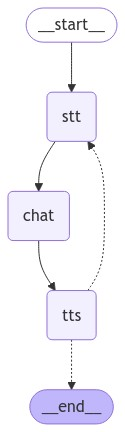

In [10]:
from IPython.display import Image, display

# Assuming `workflow_image` contains the PNG data
workflow_image = workflow.get_graph().draw_mermaid_png()

# Display the PNG image
display(Image(data=workflow_image))
